In [1]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

torch.set_default_tensor_type(torch.DoubleTensor)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
source = np.load('../../data/organs_source.npy', allow_pickle=True).tolist()
target = np.load('../../data/organs_target.npy', allow_pickle=True).tolist()

In [3]:
torch.tensor([[-8, -1]], dtype=torch.float64).dtype

torch.float64

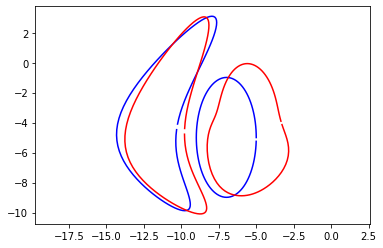

In [4]:
boundary0 = dm.MultiShape.Boundary(source[0])
boundary1 = dm.MultiShape.Boundary(source[1])

source_deformable0 = dm.Models.DeformablePoints(source[0])
source_deformable1 = dm.Models.DeformablePoints(source[1])
target_deformable0 = dm.Models.DeformablePoints(target[0])
target_deformable1 = dm.Models.DeformablePoints(target[1])

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '-r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '-r')
plt.axis('equal')
plt.show()


scale_scaling = 1.2
scaling = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[-8, -1]], dtype=torch.float64, requires_grad=True))
scale_rotation = 15
rotation = dm.DeformationModules.LocalRotation(2, scale_rotation, gd=torch.tensor([[-7.2, 7]], dtype=torch.float64, requires_grad=True))
scale_transl = 10
translation = dm.DeformationModules.GlobalTranslation(2)


attach = dm.Attachment.EuclideanPointwiseDistanceAttachment()

shoot_solver = 'torch_euler'
shoot_it = 10

In [5]:
compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]),                                                                                    dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), translation.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])

model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[rotation], [scaling, translation]], [attach, attach], sigma_bck, lam=10., constraints=constraints)
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [6]:
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, 0.1)
multishape.manifold.fill_gd(model.init_manifold.gd)
multishape.manifold.fill_cotan(model.init_manifold.cotan)
Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)


In [7]:
Ham.module.manifold[2][0]

In [ ]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})